In [5]:
# imports
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import sys
from scipy import optimize

from dreem_tools import plotting, parse

# general figure tweaks
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["font.size"] = 20
# to fight the theme
plt.rcParams["figure.facecolor"] = "white"

In [6]:
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '../..'))
sys.path.append(BASE_DIR)

ANALYSIS_DIR = os.path.join(BASE_DIR, 'scripts', 'analysis')
sys.path.append(ANALYSIS_DIR)

DATA_PATH = BASE_DIR + '/data'

In [7]:
from titration_fitting import fit_bootstrap, curve_func_new 

In [8]:
df_wt = pd.read_json(f"{DATA_PATH}/wt_mg_titra.json")
df_wt = df_wt[df_wt['exp_name'] == "2022_07_27_C0117_50mM_NaC_Mg2+_titra_CM"]
df = pd.read_json(f"{DATA_PATH}/mttr6_data_full.json")
#df = df[df["mg_conc"] != 5.0]

### style functions

In [9]:
# style functions
def publication_style_ax(ax):
    for spine in ax.spines.values():
        spine.set_linewidth(2)
    ax.tick_params(width=2)
    fsize = 24
    ax.xaxis.label.set_fontsize(fsize)
    ax.yaxis.label.set_fontsize(fsize)
    ax.tick_params(axis='both', which='major', labelsize=fsize-2)


def publication_scatter(ax, x, y, **kwargs):
    ax.scatter(x, y, s=150, **kwargs)

### plotting functions

In [10]:
def curve_func_new(conc, K, n, A):
    return A*((conc / K) ** n) / (1 + (conc / K) ** n)

def normalize_data(data):
    if np.min(data) == np.max(data):
        return data
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def normalize_data_no_min(data):
    if np.min(data) == np.max(data):
        return data
    return (data) / (np.max(data))

def fit_bootstrap(p0, datax, datay, function, yerr_systematic=0.0):
    errfunc = lambda p, x, y: function(x, p[0], p[1], p[2]) - y
    # Fit first time
    pfit, perr = optimize.leastsq(errfunc, p0, args=(datax, datay), full_output=0)
    # Get the stdev of the residuals
    residuals = errfunc(pfit, datax, datay)
    sigma_res = np.std(residuals)
    sigma_err_total = np.sqrt(sigma_res**2 + yerr_systematic**2)
    # 100 random data sets are generated and fitted
    ps = []
    for i in range(100):
        randomDelta = np.random.normal(0.0, sigma_err_total, len(datay))
        randomdataY = datay + randomDelta
        randomfit, randomcov = optimize.leastsq(
            errfunc, p0, args=(datax, randomdataY), full_output=0
        )
        ps.append(randomfit)
    ps = np.array(ps)
    mean_pfit = np.mean(ps, 0)
    # You can choose the confidence interval that you want for your
    # parameter estimates:
    Nsigma = 1.0  # 1sigma gets approximately the same as methods above
    # 1sigma corresponds to 68.3% confidence interval
    # 2sigma corresponds to 95.44% confidence interval
    err_pfit = Nsigma * np.std(ps, 0)

    pfit_bootstrap = mean_pfit
    perr_bootstrap = err_pfit
    return pfit_bootstrap, perr_bootstrap

def compute_mg_1_2(mg_conc, norm_data ):
    pstart = [1, 1, 1]
    pfit, perr = fit_bootstrap(pstart, mg_conc, norm_data, curve_func_new)
    return pfit, perr

def publication_titration_plot(g, name, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
        
    mg_conc = list(g["mg_conc"])
    data = list(g["gaaa_avg"])
    norm_data = -normalize_data_no_min(np.array(data)) + 1
    r = compute_mg_1_2(mg_conc, norm_data)
    print(r[0])
    plt.scatter(g["mg_conc"], norm_data, s=100)
    xs, ys = [], []
    for j in np.arange(0, 40, 0.01):
        p = r[0]
        y = curve_func_new(j, p[0], p[1], p[2])
        xs.append(j)
        ys.append(y)
    #plt.fill_between(xs, ys-r[1][0], ys+r[1][0], alpha=0.2, lw=0)
    plt.plot(xs, ys, label=name, lw=3)


def r2(x, y):
    return round(stats.pearsonr(x, y)[0] ** 2, 3)

def plot_reg_with_r2(x, y, data):
    fig, ax = plt.subplots()
    sns.regplot(x=x, y=y, data=data, line_kws={"label": r2(data[x], data[y])}, ax=ax)
    plt.legend()
    return ax

[0.2286868  1.43320114 0.93730736]
[0.21541323 1.26050749 0.9504864 ]
[3.60484413 1.23401125 0.78149507]


<ipython-input-10-697947beb9ef>:2: RuntimeWarning: invalid value encountered in power
  return A*((conc / K) ** n) / (1 + (conc / K) ** n)


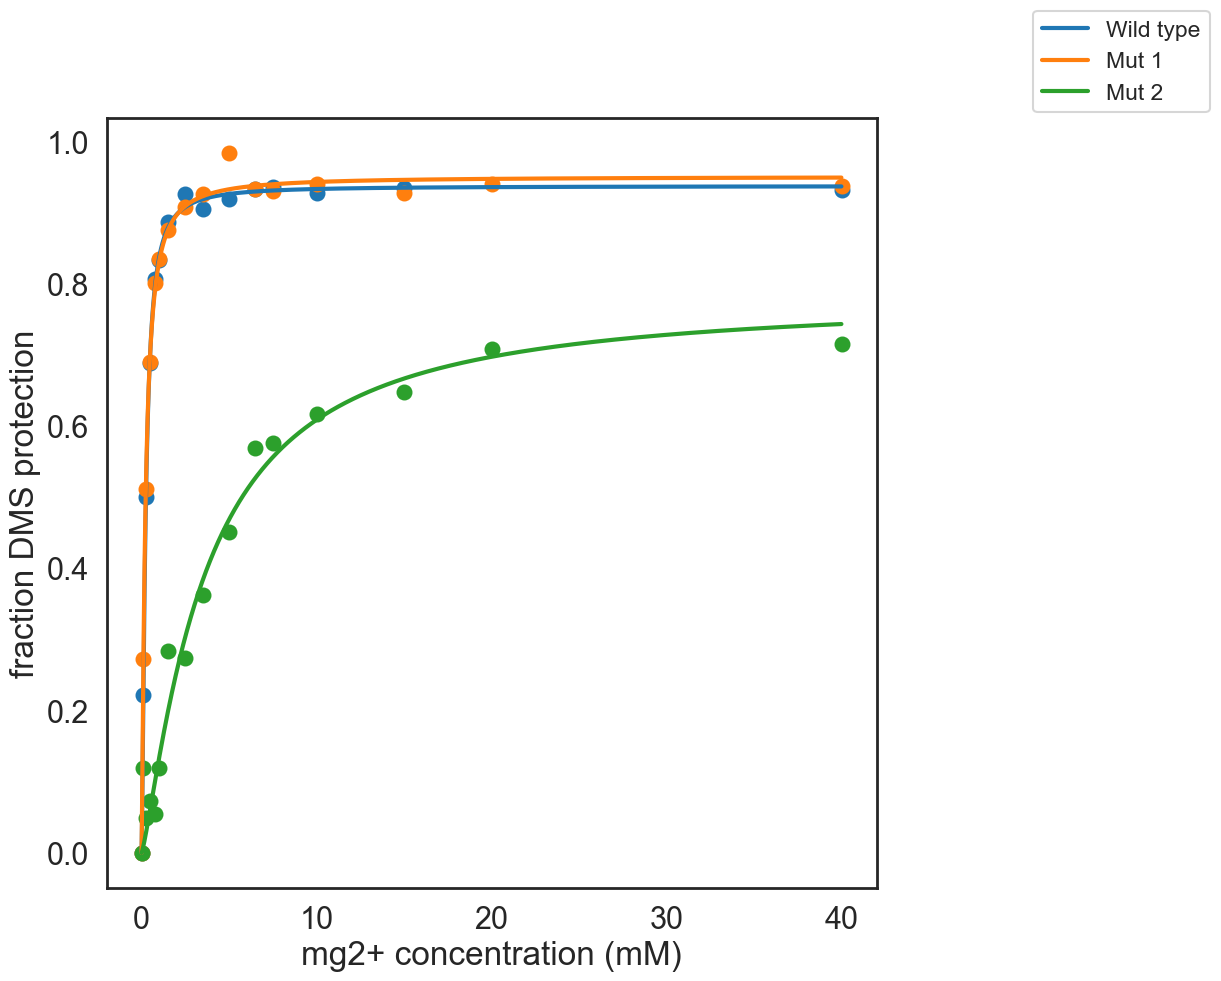

In [11]:
fig, ax = plt.subplots()
df_upper = df[df["name"] == "CAUGG_CCUAAA"]
df_lower = df[df["name"] == "CACGG_CCCUAAC"]
publication_titration_plot(df_wt, "Wild type", ax=ax)
publication_titration_plot(df_upper, "Mut 1", ax=ax)
publication_titration_plot(df_lower, "Mut 2", ax=ax)
publication_style_ax(ax)
ax.set_ylabel("fraction DMS protection")
ax.set_xlabel("mg2+ concentration (mM)")
ax.set_box_aspect(1)
fig.legend()


In [12]:
df_sub = df[~df["name"].isin(["CAUGA_UCUAAA", "UAUGG_CUUAAC", "UACGG_CCUACA", "CACGG_CCUCAC", "CAUGC_GCUCAA", "CAUGC_GCUGAA"])].copy()
df_sub['ln_gaaa_avg'] = np.log(df_sub['gaaa_avg'])
df_sub['ln_mg_1_2'] = np.log(df_sub['mg_1_2'])

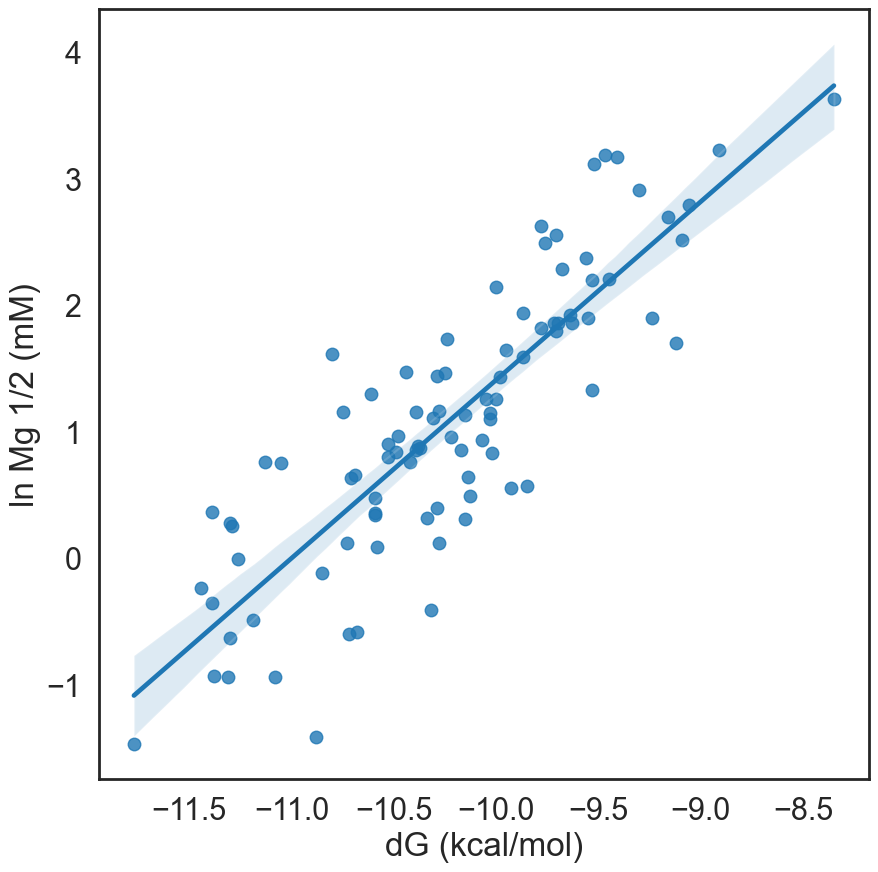

In [13]:
df_sum = df_sub.drop_duplicates(subset='name', keep='first')
df_sum.sort_values("mg_1_2")[["name", "dg", "mg_1_2"]]
fig, ax = plt.subplots()
sns.regplot(x="dg", y="ln_mg_1_2", data=df_sum, ax=ax)
ax.set_box_aspect(1)
ax.set_xlabel("dG (kcal/mol)")
ax.set_ylabel("ln Mg 1/2 (mM)")
publication_style_ax(ax)


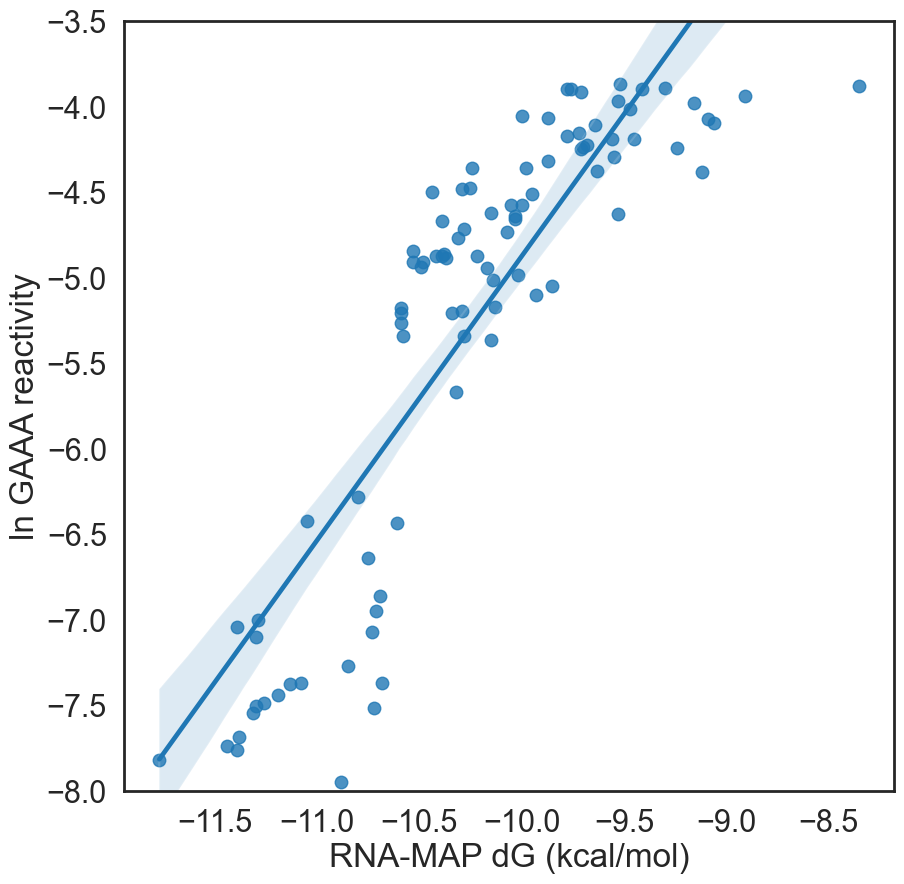

In [14]:
df_sub_mg = df_sub[df_sub["mg_conc"] == 5.0].copy()
fig, ax = plt.subplots()
sns.regplot(x="dg", y="ln_gaaa_avg", data=df_sub_mg, ax=ax)
ax.set_box_aspect(1)
ax.set_xlabel("RNA-MAP dG (kcal/mol)")
ax.set_ylabel("ln GAAA reactivity")
ax.set_ylim(-8, -3.5)
publication_style_ax(ax)

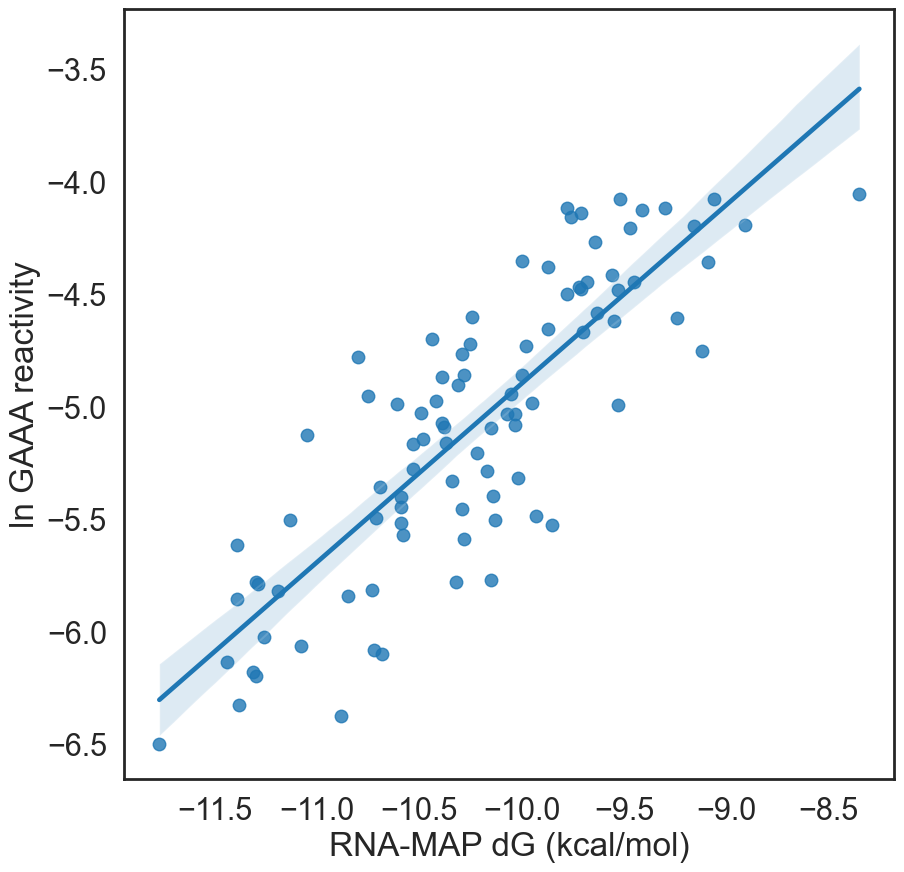

In [15]:
df_sub_mg = df_sub[df_sub["mg_conc"] == 10].copy()
fig, ax = plt.subplots()
sns.regplot(x="dg", y="ln_gaaa_avg", data=df_sub_mg, ax=ax)
ax.set_box_aspect(1)
ax.set_xlabel("RNA-MAP dG (kcal/mol)")
ax.set_ylabel("ln GAAA reactivity")
publication_style_ax(ax)

In [16]:
mg_values = []